# Cross Correlation Check

### Import Python libraries

In [1]:
import pathlib
import glob
from datetime import datetime

import rasterio
from rasterio.windows import from_bounds
from osgeo import gdal
import shapely
from shapely import wkt
from ipyfilechooser import FileChooser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
from PIL import Image as PILImage

PILImage.MAX_IMAGE_PIXELS = None

import opensarlab_lib as asfn

### Define some later-used methods and variables

In [2]:
def save_tiff_as_png(save_path_and_name: str):
    """
    Convert dataframe of tiff into png.
    """
    img = Image.open(save_path_and_name).convert('RGB')
    img.save(save_path_and_name + ".png")
    
def convert_rast_to_df(rasterio_obj, window=None, flatten=None):
    
    def flat(df):
        return df[(df > np.percentile(df, 1)) & (df < np.percentile(df, 99))]
    if not flatten:
        flatten = flat
    
    if window:
        raster0 = rasterio_obj.read(1, window=window)
    else:
        raster0 = rasterio_obj.read(1)
    df = pd.DataFrame(raster0)
    
    df = flatten(df)
    
    return df
    
# Get working directory of notebook
CWD = pathlib.Path().absolute()
CWD

# Note: 8x8 tiles will use about 82 GB of RAM  
X_NUM = 8
Y_NUM = 8

### Choose tiff files to compare.

In [3]:
# Choose the tiffs
fc1 = FileChooser(f'{CWD}/data/')
display(fc1)

FileChooser(path='/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data', filename=''…

In [4]:
# Choose the tiffs
fc2 = FileChooser(f'{CWD}/data/')
display(fc2)

FileChooser(path='/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data', filename=''…

In [5]:
reference_path = fc1.selected_path
reference_file = fc1.selected_filename
print(reference_path, reference_file)

secondary_path = fc2.selected_path
secondary_file = fc2.selected_filename
print(secondary_path, secondary_file)

/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data/S1A_IW_20230108T015040_DVP_RTC30_G_gpuned_12E6 S1A_IW_20230108T015040_DVP_RTC30_G_gpuned_12E6_VV.tif
/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation/data/S1A_IW_20230108T135249_DVP_RTC30_G_gpuned_147E S1A_IW_20230108T135249_DVP_RTC30_G_gpuned_147E_VV.tif


In [6]:
!mkdir -p {CWD}/work/
!cp {reference_path}/{reference_file} {CWD}/work/reference.tif
!cp {secondary_path}/{secondary_file} {CWD}/work/secondary.tif

### Convert tiffs to rasterio objects

In [7]:
with asfn.work_dir(f"{CWD}/work/"):
    reference = rasterio.open('reference.tif')    
    secondary = rasterio.open('secondary.tif')
    
    print(reference.meta)
    print(secondary.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9594, 'height': 7699, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 302070.0,
       0.0, -30.0, 3958560.0)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 9626, 'height': 7603, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 274860.0,
       0.0, -30.0, 3833340.0)}


### Plot original reference and secondary scenes

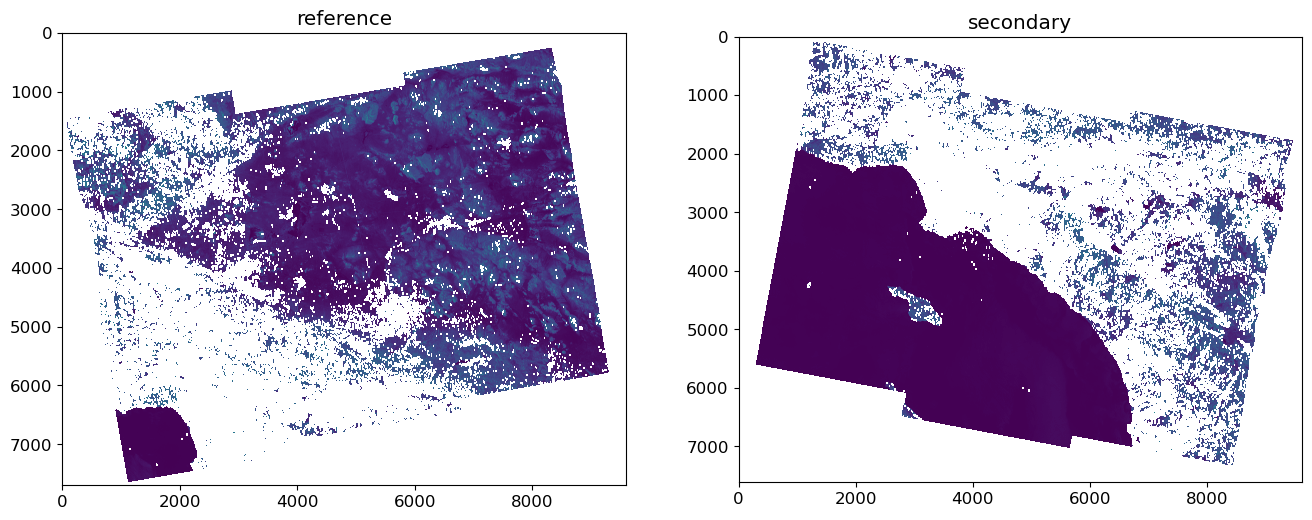

In [8]:
df_reference = convert_rast_to_df(reference)
df_secondary = convert_rast_to_df(secondary)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, title="reference")
ax2 = fig.add_subplot(122, title="secondary")

ax1.imshow(df_reference)
ax2.imshow(df_secondary)

### Find smallest common superset area and transform the scenes

In [9]:
ref_bound = reference.bounds
sec_bound = secondary.bounds

superset = {
    'left': min(ref_bound.left, sec_bound.left),
    'bottom': min(ref_bound.bottom, sec_bound.bottom), 
    'right': max(ref_bound.right, sec_bound.right), 
    'top': max(ref_bound.top, sec_bound.top)
}

print(ref_bound)
print(sec_bound)
print(superset)

with asfn.work_dir(f"{CWD}/work/"):
    gdal.Warp(
            str('reference_superset.tif'), 
            str('reference.tif'),
            outputBounds=(
                superset['left'], 
                superset['bottom'],
                superset['right'],
                superset['top'],
            ),
            outputBoundsSRS=reference.crs #"EPSG:4326"
        )
    
    gdal.Warp(
            str('secondary_superset.tif'), 
            str('secondary.tif'),
            outputBounds=(
                superset['left'], 
                superset['bottom'],
                superset['right'],
                superset['top'],
            ),
            outputBoundsSRS=secondary.crs #"EPSG:4326"
        )

BoundingBox(left=302070.0, bottom=3727590.0, right=589890.0, top=3958560.0)
BoundingBox(left=274860.0, bottom=3605250.0, right=563640.0, top=3833340.0)
{'left': 274860.0, 'bottom': 3605250.0, 'right': 589890.0, 'top': 3958560.0}


### Show superset-ed scenes

In [10]:
with asfn.work_dir(f"{CWD}/work/"):
    reference_superset = rasterio.open('reference_superset.tif')    
    secondary_superset = rasterio.open('secondary_superset.tif')

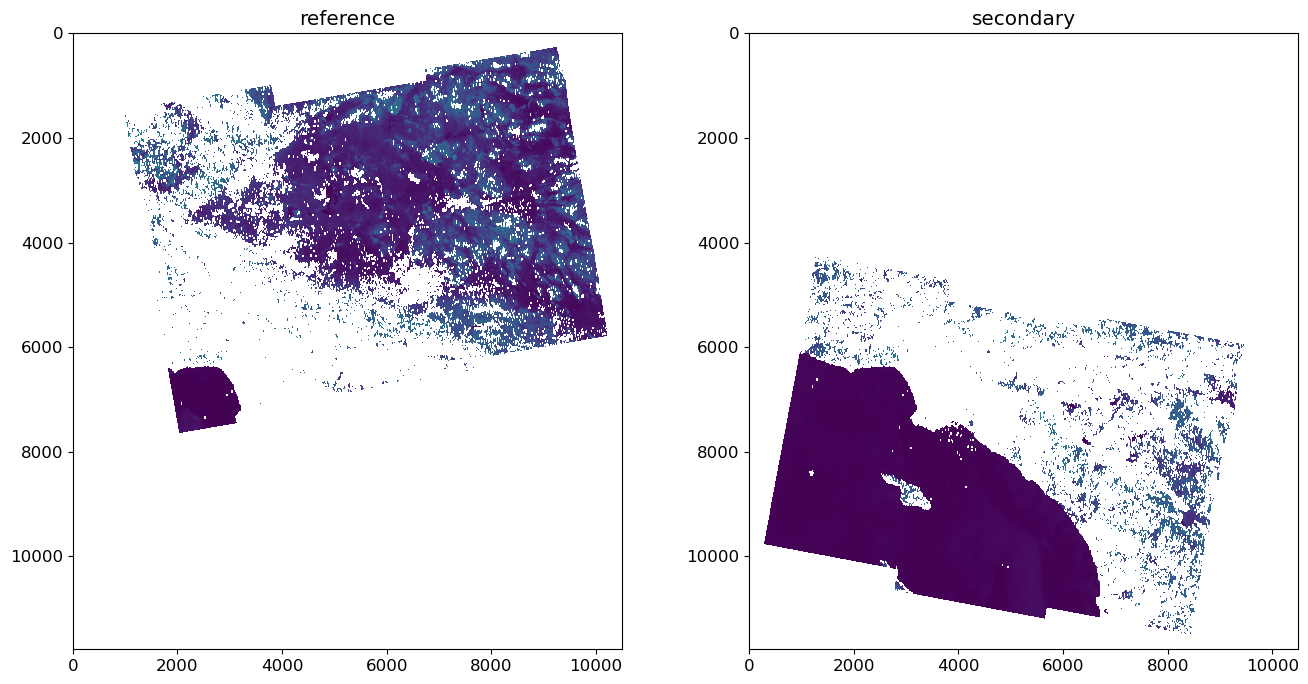

In [11]:
df_reference_superset = convert_rast_to_df(reference_superset)
df_secondary_superset = convert_rast_to_df(secondary_superset)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, title="reference")
ax2 = fig.add_subplot(122, title="secondary")

ax1.imshow(df_reference_superset)
ax2.imshow(df_secondary_superset)

### Perform cross-correlation on the tiffs (replacing Nans with Zeroes)

In [12]:
with asfn.work_dir(f"{CWD}/work/"):

    # Find cross correlation
    # https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation

    print("Replacing NaNs with zero....")
    shift, error, phase = phase_cross_correlation(
        df_reference_superset.replace(np.nan,0), 
        df_secondary_superset.replace(np.nan,0)
    )
    print(f"Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
    print(f"Translation invariant normalized RMS error between reference_image and moving_image: {error}")
    print(f"Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")

Replacing NaNs with zero....
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Translation invariant normalized RMS error between reference_image and moving_image: 0.9999999999999998
Global phase difference between the two images (should be zero if images are non-negative).: -2.5641411216525967e-09



### Show where the NANs are in the tiffs

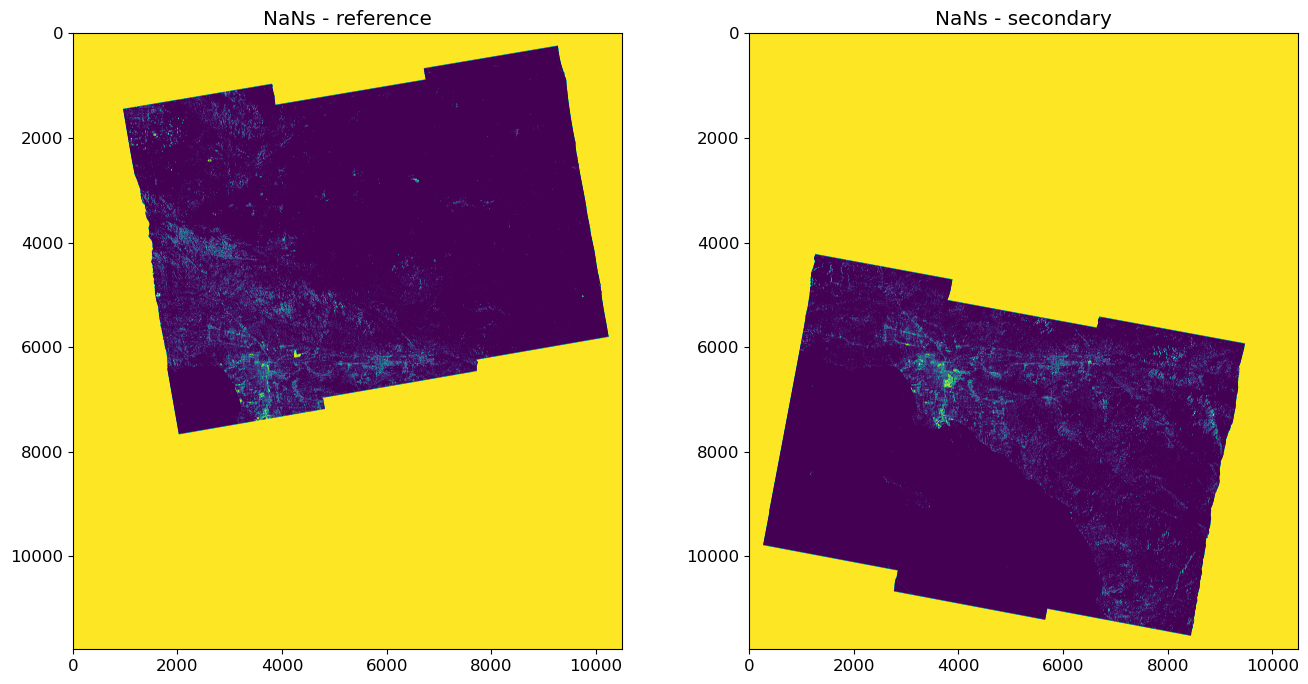

In [13]:
nan_reference_mask = np.isnan(df_reference_superset)
nan_moving_mask = np.isnan(df_secondary_superset)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, title='NaNs - reference')
ax2 = fig.add_subplot(122, title='NaNs - secondary')
ax1.imshow(nan_reference_mask)
ax2.imshow(nan_moving_mask)

### Perform cross-correlation on the tiffs (Masking Nans)

In [14]:
with asfn.work_dir(f"{CWD}/work/"):
    # Find cross correlation
    # https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation
    
    print("Using NaN mask...")
    shift = phase_cross_correlation(df_reference_superset, df_secondary_superset, reference_mask=~nan_reference_mask, moving_mask=~nan_moving_mask)
    print(f"Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
    print(f"No error or phase given with masks.")

Using NaN mask...
Shift vector (in pixels) required to register moving_image with reference_image: [-80.   0.]
No error or phase given with masks.


### Tile scenes into equal rectangles/squares

Save files as PNGs as well

In [15]:
# https://gis.stackexchange.com/a/306862
from shapely import geometry
from rasterio.mask import mask

# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim
def splitImageIntoCells(img, filename, x_num=1, y_num=1):    
    x_dim = img.shape[1] // x_num
    y_dim = img.shape[0] // y_num

    x, y = 0, 0
    for y_iter in range(y_num):
        y = y_iter * y_dim
        for x_iter in range(x_num):
            x = x_iter * x_dim
            
            filepath = f'{filename}_{y_iter}_{x_iter}.tif'
            print(f"Creating tile {filepath}...")
            
            # Get tile geometry
            corner1 = img.transform * (x, y)
            corner2 = img.transform * (x + x_dim, y + y_dim)
            geom = geometry.box(corner1[0], corner1[1], corner2[0], corner2[1])
            
            # Get cell 
            crop, cropTransform = mask(img, [geom], crop=True)
            img.meta.update(
                {
                    "driver": "GTiff",
                    "height": crop.shape[1],
                    "width": crop.shape[2],
                    "transform": cropTransform,
                    "crs": img.crs
                }
            )
            
            with rasterio.open(filepath, "w", **img.meta) as out:
                out.write(crop)
                
            rbg = PILImage.open(filepath).convert('RGB')
            rbg.save(filepath + ".png")

In [16]:
start_time = datetime.now()
print(f"Start time is {start_time}\n")

!mkdir -p {CWD}/work/reference_tiles/
with asfn.work_dir(f"{CWD}/work/reference_tiles"):
    splitImageIntoCells(reference_superset, 'reference', x_num=X_NUM, y_num=Y_NUM)
    
end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")

Start time is 2023-04-07 19:29:53.648513

Creating tile reference_0_0.tif...
Creating tile reference_0_1.tif...
Creating tile reference_0_2.tif...
Creating tile reference_0_3.tif...
Creating tile reference_0_4.tif...
Creating tile reference_0_5.tif...
Creating tile reference_0_6.tif...
Creating tile reference_0_7.tif...
Creating tile reference_1_0.tif...
Creating tile reference_1_1.tif...
Creating tile reference_1_2.tif...
Creating tile reference_1_3.tif...
Creating tile reference_1_4.tif...
Creating tile reference_1_5.tif...
Creating tile reference_1_6.tif...
Creating tile reference_1_7.tif...
Creating tile reference_2_0.tif...
Creating tile reference_2_1.tif...
Creating tile reference_2_2.tif...
Creating tile reference_2_3.tif...
Creating tile reference_2_4.tif...
Creating tile reference_2_5.tif...
Creating tile reference_2_6.tif...
Creating tile reference_2_7.tif...
Creating tile reference_3_0.tif...
Creating tile reference_3_1.tif...
Creating tile reference_3_2.tif...
Creating tile

In [17]:
start_time = datetime.now()
print(f"Start time is {start_time}\n")

!mkdir -p {CWD}/work/secondary_tiles/
with asfn.work_dir(f"{CWD}/work/secondary_tiles"):
    splitImageIntoCells(secondary_superset, 'secondary', x_num=X_NUM, y_num=Y_NUM)
    
end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")

Start time is 2023-04-07 19:35:57.682393

Creating tile secondary_0_0.tif...
Creating tile secondary_0_1.tif...
Creating tile secondary_0_2.tif...
Creating tile secondary_0_3.tif...
Creating tile secondary_0_4.tif...
Creating tile secondary_0_5.tif...
Creating tile secondary_0_6.tif...
Creating tile secondary_0_7.tif...
Creating tile secondary_1_0.tif...
Creating tile secondary_1_1.tif...
Creating tile secondary_1_2.tif...
Creating tile secondary_1_3.tif...
Creating tile secondary_1_4.tif...
Creating tile secondary_1_5.tif...
Creating tile secondary_1_6.tif...
Creating tile secondary_1_7.tif...
Creating tile secondary_2_0.tif...
Creating tile secondary_2_1.tif...
Creating tile secondary_2_2.tif...
Creating tile secondary_2_3.tif...
Creating tile secondary_2_4.tif...
Creating tile secondary_2_5.tif...
Creating tile secondary_2_6.tif...
Creating tile secondary_2_7.tif...
Creating tile secondary_3_0.tif...
Creating tile secondary_3_1.tif...
Creating tile secondary_3_2.tif...
Creating tile

### Plot Reference, Secondary tiles and Correlation (zeroed NANs) values

Start time is 2023-04-07 19:42:06.712593

Rendering ./reference_tiles/reference_0_0.tif...
Rendering ./secondary_tiles/secondary_0_0.tif...
Replacing NaNs with zero....


/home/jovyan/.local/envs/opera-rtc-cross-corr/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:107: RuntimeWarning: invalid value encountered in divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\


Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Translation invariant normalized RMS error between reference_image and moving_image: nan
Global phase difference between the two images (should be zero if images are non-negative).: 0.0

Rendering ./reference_tiles/reference_0_1.tif...
Rendering ./secondary_tiles/secondary_0_1.tif...
Replacing NaNs with zero....
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Translation invariant normalized RMS error between reference_image and moving_image: nan
Global phase difference between the two images (should be zero if images are non-negative).: 0.0

Rendering ./reference_tiles/reference_0_2.tif...
Rendering ./secondary_tiles/secondary_0_2.tif...
Replacing NaNs with zero....
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
Translation invariant normalized RMS error between reference_image and moving_image: nan
Global phase dif

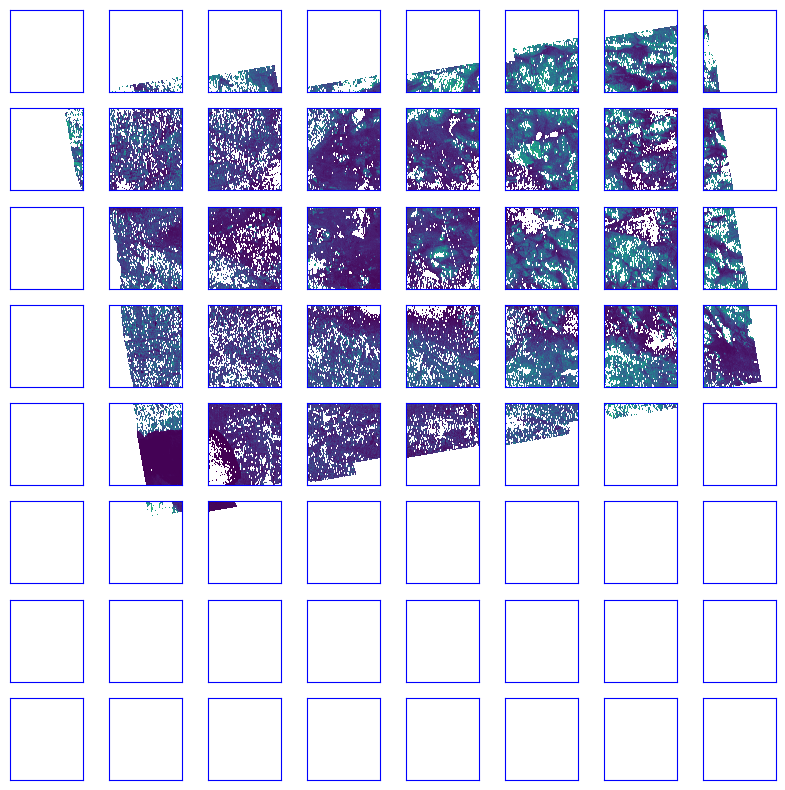

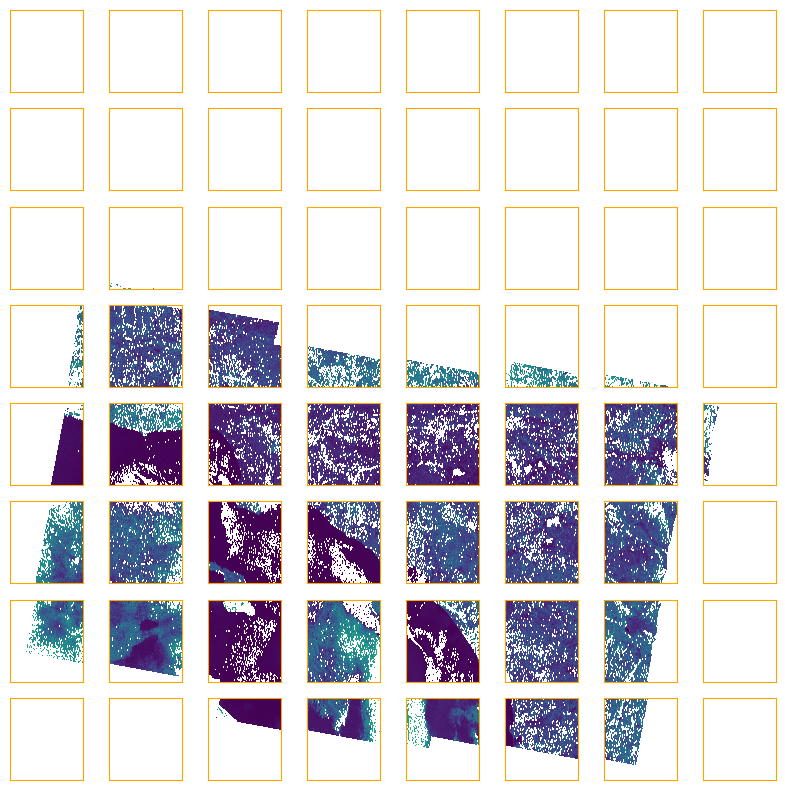

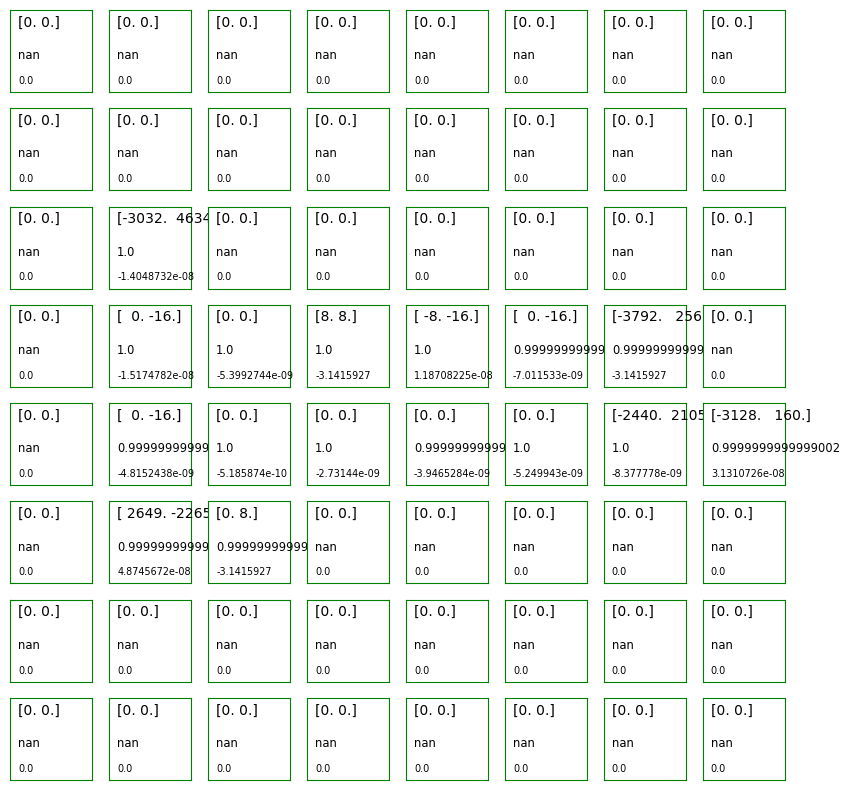

In [18]:
with asfn.work_dir(f"{CWD}/work"):
    
    start_time = datetime.now()
    print(f"Start time is {start_time}\n")
    
    ref = plt.figure(figsize=(10,10))
    sec = plt.figure(figsize=(10,10))
    corr = plt.figure(figsize=(10,10))
    
    cross_corr_results = []
    
    count = 1
    for i in range(X_NUM):
        
        #if i not in [1]:
        #    continue
            
        for j in range(Y_NUM):
            
        #    if j not in [1]:
        #        continue
            
            ###### Reference
            ref_file_path = f'./reference_tiles/reference_{i}_{j}.tif'
            print(f"Rendering {ref_file_path}...")
            rast = rasterio.open(ref_file_path)
            df_ref = convert_rast_to_df(rast)
            
            ax_ref = ref.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
            ax_ref.spines[:].set_color('blue')
            ax_ref.imshow(df_ref)
            
            ###### Secondary
            sec_file_path = f'./secondary_tiles/secondary_{i}_{j}.tif'
            print(f"Rendering {sec_file_path}...")
            rast = rasterio.open(sec_file_path)
            df_sec = convert_rast_to_df(rast)
            
            ax_sec = sec.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
            ax_sec.spines[:].set_color('orange')
            ax_sec.imshow(df_sec)
            
            ####### Do cross corr
            # Find cross correlation
            # https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation

            print("Replacing NaNs with zero....")
            shift, error, phase = phase_cross_correlation(
                df_ref.replace(np.nan,0), 
                df_sec.replace(np.nan,0)
            )
            print(f"Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
            print(f"Translation invariant normalized RMS error between reference_image and moving_image: {error}")
            print(f"Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")
            
            cross_corr_results.append({
                "ref_file": ref_file_path,
                "sec_file": sec_file_path,
                "shift": shift, 
                "error": error, 
                "phase": phase
            })
            
            ax_corr = corr.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
            ax_corr.spines[:].set_color('green')
            ax_corr.text(0.1, 0.8, str(shift), transform = ax_corr.transAxes, fontsize='small')
            ax_corr.text(0.1, 0.4, str(error), transform = ax_corr.transAxes, fontsize='x-small')
            ax_corr.text(0.1, 0.1, str(phase), transform = ax_corr.transAxes, fontsize='xx-small')
            
            ######
            
            count = count + 1
            
    ref.show()
    sec.show()
    corr.show()
    
    del ref
    del sec
    del corr
    
    end_time = datetime.now()
    print(f"\nEnd time is {end_time}")
    print(f"Time elapsed is {end_time - start_time}\n")

### Plot Reference, Secondary tiles and Correlation (masked NANs) values

Start time is 2023-04-07 21:51:03.863724

Rendering ./reference_tiles/reference_0_0.tif...
Rendering ./secondary_tiles/secondary_0_0.tif...
Using NaN mask...
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
No error or phase given with masks.
Rendering ./reference_tiles/reference_0_1.tif...
Rendering ./secondary_tiles/secondary_0_1.tif...
Using NaN mask...
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
No error or phase given with masks.
Rendering ./reference_tiles/reference_0_2.tif...
Rendering ./secondary_tiles/secondary_0_2.tif...
Using NaN mask...
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
No error or phase given with masks.
Rendering ./reference_tiles/reference_0_3.tif...
Rendering ./secondary_tiles/secondary_0_3.tif...
Using NaN mask...
Shift vector (in pixels) required to register moving_image with reference_image: [0. 0.]
No error or phase given with m

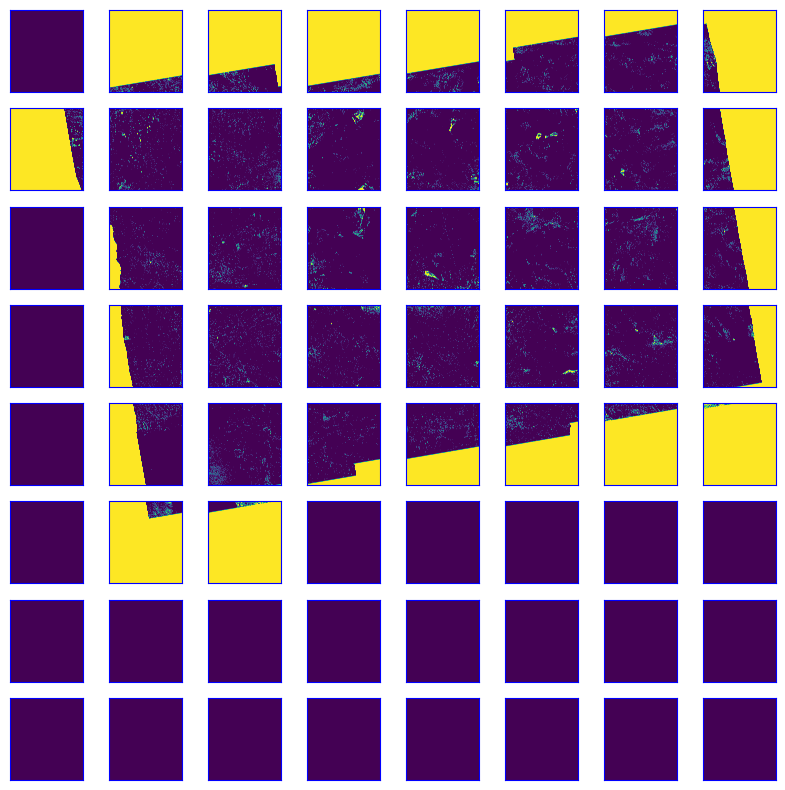

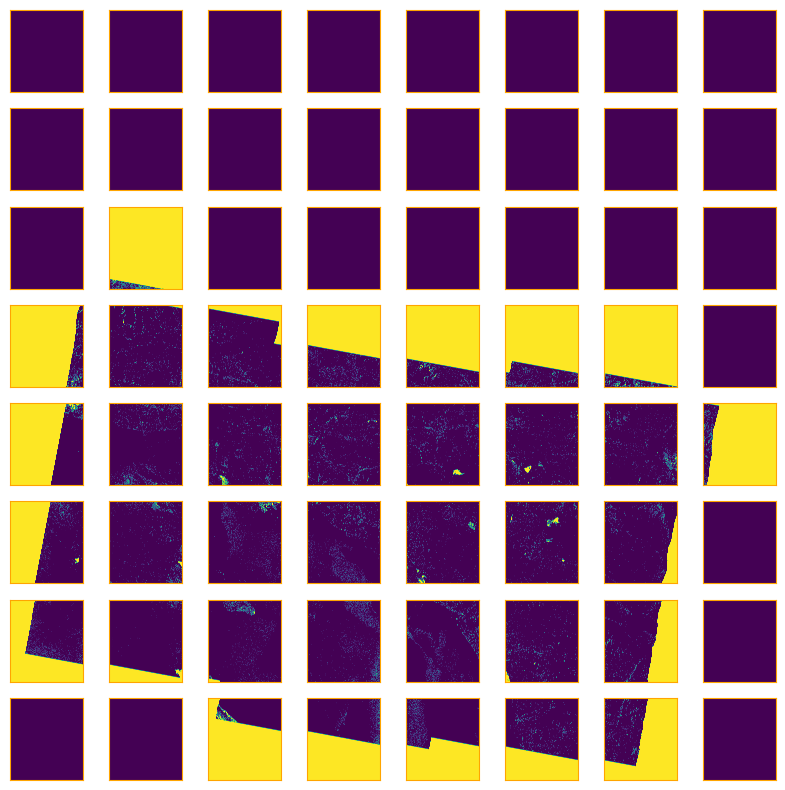

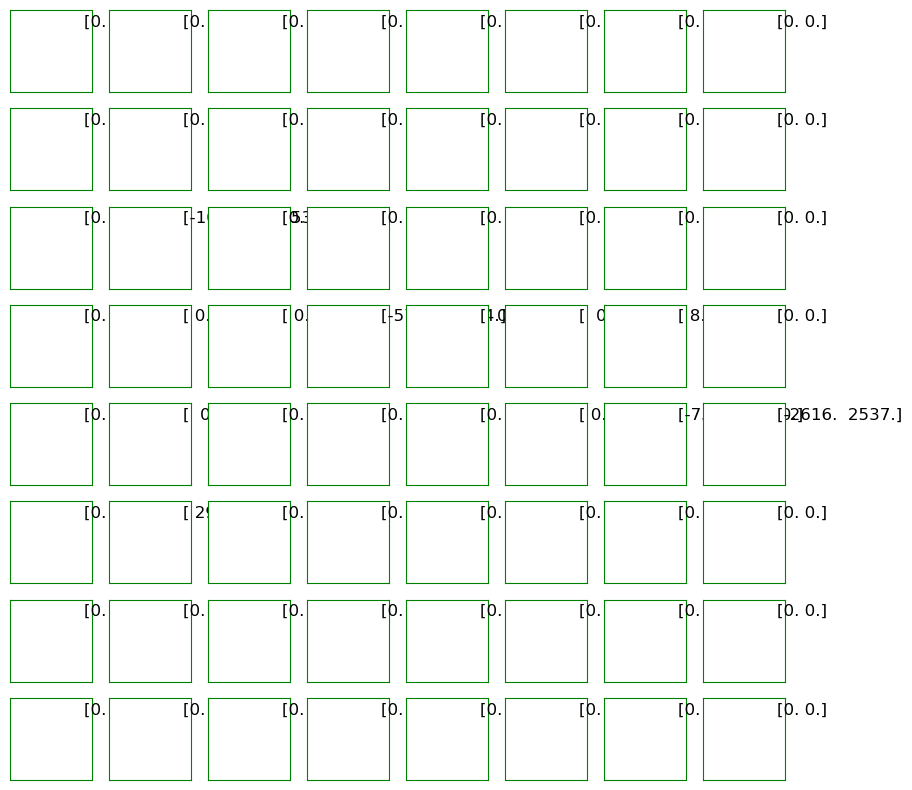

In [40]:
with asfn.work_dir(f"{CWD}/work"):
    
    start_time = datetime.now()
    print(f"Start time is {start_time}\n")
    
    ref = plt.figure(figsize=(10,10))
    sec = plt.figure(figsize=(10,10))
    corr = plt.figure(figsize=(10,10))
    
    masked_cross_corr_results = []
    
    X_NUM = 8
    Y_NUM = 8
    
    count = 1
    for i in range(X_NUM):
        
        #if i not in [1]:
        #    continue
            
        for j in range(Y_NUM):
            
        #    if j not in [1]:
        #        continue
            
            ###### Reference
            ref_file_path = f'./reference_tiles/reference_{i}_{j}.tif'
            print(f"Rendering {ref_file_path}...")
            rast = rasterio.open(ref_file_path)
            df_ref = convert_rast_to_df(rast)
            
            nan_df_ref = np.isnan(df_ref)
            
            ax_ref = ref.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
            ax_ref.spines[:].set_color('blue')
            ax_ref.imshow(nan_df_ref)
            
            ###### Secondary
            sec_file_path = f'./secondary_tiles/secondary_{i}_{j}.tif'
            print(f"Rendering {sec_file_path}...")
            rast = rasterio.open(sec_file_path)
            df_sec = convert_rast_to_df(rast)
            
            nan_df_sec = np.isnan(df_sec)
            
            ax_sec = sec.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
            ax_sec.spines[:].set_color('orange')
            ax_sec.imshow(nan_df_sec)
            
            ####### Do cross corr
            # Find cross correlation
            # https://scikit-image.org/docs/stable/api/skimage.registration.html#skimage.registration.phase_cross_correlation
            
            print("Using NaN mask...")
            shift = phase_cross_correlation(df_ref, df_sec, reference_mask=~nan_df_ref, moving_mask=~nan_df_sec)
            print(f"Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
            print(f"No error or phase given with masks.")
            
            masked_cross_corr_results.append({
                "ref_file": ref_file_path,
                "sec_file": sec_file_path,
                "shift": shift
            })
            
            ax_corr = corr.add_subplot(X_NUM, Y_NUM, count, xticks=[], yticks=[])
            ax_corr.spines[:].set_color('green')
            ax_corr.text(0.9, 0.8, str(shift), transform = ax_corr.transAxes, fontsize='medium')
            
            ######
            
            count = count + 1
    
    ref.show()
    sec.show()
    corr.show()
    
    end_time = datetime.now()
    print(f"\nEnd time is {end_time}")

In [44]:
from pprint import pprint
pprint(cross_corr_results)

[{'error': nan,
  'phase': 0.0,
  'ref_file': './reference_tiles/reference_0_0.tif',
  'sec_file': './secondary_tiles/secondary_0_0.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'error': nan,
  'phase': 0.0,
  'ref_file': './reference_tiles/reference_0_1.tif',
  'sec_file': './secondary_tiles/secondary_0_1.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'error': nan,
  'phase': 0.0,
  'ref_file': './reference_tiles/reference_0_2.tif',
  'sec_file': './secondary_tiles/secondary_0_2.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'error': nan,
  'phase': 0.0,
  'ref_file': './reference_tiles/reference_0_3.tif',
  'sec_file': './secondary_tiles/secondary_0_3.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'error': nan,
  'phase': 0.0,
  'ref_file': './reference_tiles/reference_0_4.tif',
  'sec_file': './secondary_tiles/secondary_0_4.tif',
  'shift': array([0., 0.], dtype=float32)},
 {'error': nan,
  'phase': 0.0,
  'ref_file': './reference_tiles/reference_0_5.tif',
  'se

In [45]:
from pprint import pprint
pprint(masked_cross_corr_results)

[{'ref_file': './reference_tiles/reference_0_0.tif',
  'sec_file': './secondary_tiles/secondary_0_0.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_1.tif',
  'sec_file': './secondary_tiles/secondary_0_1.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_2.tif',
  'sec_file': './secondary_tiles/secondary_0_2.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_3.tif',
  'sec_file': './secondary_tiles/secondary_0_3.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_4.tif',
  'sec_file': './secondary_tiles/secondary_0_4.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_5.tif',
  'sec_file': './secondary_tiles/secondary_0_5.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_6.tif',
  'sec_file': './secondary_tiles/secondary_0_6.tif',
  'shift': array([0., 0.])},
 {'ref_file': './reference_tiles/reference_0_7.tif',
  

In [43]:
######
# Get actual size of python variables that are taking up RAM
# https://stackoverflow.com/a/51046503
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

         df_reference_superset: 471.8 MiB
         df_secondary_superset: 471.8 MiB
                        df_ref: 471.8 MiB
                        df_sec: 471.8 MiB
                  df_reference: 281.8 MiB
                  df_secondary: 279.2 MiB
            nan_reference_mask: 117.9 MiB
               nan_moving_mask: 117.9 MiB
                    nan_df_ref: 117.9 MiB
                    nan_df_sec: 117.9 MiB
